<a href="https://colab.research.google.com/github/Saltizm/Data-mining-group-project/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import sklearn as sk;
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
import tqdm;
import os;
import sys;

In [172]:
# # # mount
# from google.colab import drive
# drive.mount('/content/drive')

In [173]:
if os.path.isdir(r'C:\Users\User\Desktop\Data-mining-group-project'):
    os.chdir(r'C:\Users\User\Desktop\Data-mining-group-project') #local
elif os.path.isdir(r'/content/drive/MyDrive/data mining'):
    os.chdir(r'/content/drive/MyDrive/data mining') #google drive
try:
    train = pd.read_csv(open('UNSW_NB15_training-set.csv'))
    test = pd.read_csv(open('UNSW_NB15_testing-set.csv'))
except FileNotFoundError as e:
    print(f"error: {e}\nTry changing the training data directory in 'os.chdir'")

In [174]:
# if data too big (use for testing)
train = train.sample(frac=0.1, random_state=42)
test = test.sample(frac=0.1, random_state=42)

In [175]:
print(train.shape, test.shape)
# 45 attributes

(17534, 45) (8233, 45)


In [176]:
train.isnull().any(axis=1).sum()

0

In [177]:
test.isnull().any(axis=1).sum()

0

In [178]:
# import files
x_train, y_train = train.iloc[:, :-2].sample(frac=1, random_state=42), train.iloc[:, -1:].sample(frac=1, random_state=42)
x_test, y_test = test.iloc[:, :-2].sample(frac=1, random_state=42), test.iloc[:, -1:].sample(frac=1, random_state=42)

In [179]:
def show_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (lower_bound, upper_bound)

# data cleaning (replacement)
def replace_outliers_iqr(df, cols):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            lower_bound, upper_bound = show_outliers_iqr(df[col])
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# data filtering
def remove_outliers_iqr(df, cols):
    df = df.copy()
    overall_mask = pd.Series(True, index=df.index)

    for col in cols:
        if col in df.columns:
            lower_bound, upper_bound = show_outliers_iqr(df[col])
            col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
            overall_mask = overall_mask & col_mask

    df = df[overall_mask]
    return df

def risky_show_shape(*arg):
    if len(arg) == 2:
        print("train/test")
        print(arg[0].shape, arg[1].shape)
    else:
        print("x_train/x_test/y_train/y_test")
        for df in args:
            print(df.shape)

def run_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

def bin_decision(series, threshold=0.2):
    keep = []

    val_count = series.value_counts()
    for col in val_count.index:
        if val_count[col] / series.shape[0] > threshold:
            keep.append(col)
    return keep

def binning(df, col, values):
    df = df.copy()

    for val in values:
        df[col].replace(val, 'Others', inplace=True)
    return df

def col_encoder(df, col):
    df = df.copy()

    encoded_col = pd.get_dummies(df[col], prefix=col)
    df_encoded = pd.concat([df.drop(col, axis=1), encoded_col], axis=1)
    return df_encoded

message = """
show_outliers_iqr(series) -
return an array where index=0 is the lower bound and index=1 is the upper bound.

replace_outliers_iqr(df, cols) -
creates a copy of "df". replace the samples with attributes > upper_bound or < lower_bound with upper_bound or lower_bound.

remove_outliers_iqr(df, cols) -
creates a copy of "df". remove the samples with attributes > upper_bound or < lower_bound.

risky_show_shape(*data) -
in the format of train/test. Or x_train, x_test, y_train, y_test.

run_model(model, x_train, y_train, x_test, y_test) -
runs the model and returns the prediction.

bin_decision(series, threshold=0.2) -
get a list of value that represent less than x% of the total.

binning(df, col, values) -
replace a list of values with 'others' for one hot encoding later on.
"""
print(message)


show_outliers_iqr(series) -
return an array where index=0 is the lower bound and index=1 is the upper bound.

replace_outliers_iqr(df, cols) -
creates a copy of "df". replace the samples with attributes > upper_bound or < lower_bound with upper_bound or lower_bound.

remove_outliers_iqr(df, cols) -
creates a copy of "df". remove the samples with attributes > upper_bound or < lower_bound.

risky_show_shape(*data) -
in the format of train/test. Or x_train, x_test, y_train, y_test.

run_model(model, x_train, y_train, x_test, y_test) -
runs the model and returns the prediction.

bin_decision(series, threshold=0.2) -
get a list of value that represent less than x% of the total.

binning(df, col, values) -
replace a list of values with 'others' for one hot encoding later on.



In [180]:
# find numerical and non numerical fields
numerical_cols = x_train.select_dtypes(include=np.number).columns
non_numerical_cols = x_train.select_dtypes(exclude=np.number).columns

In [181]:
# find continuous and uniary fields (low and high cardinality)

low_cardinality_cols = []
high_cardinality_cols = []
continuous_cols = []

# Define a threshold for low cardinality. For example, less than 20 unique values.
CARDINALITY_THRESHOLD = 50

for col in numerical_cols:
    if col in ['id', 'label']:
        continue

    unique_count = x_train[col].nunique()
    if unique_count <= CARDINALITY_THRESHOLD:
        low_cardinality_cols.append(col)
    else:
        continuous_cols.append(col)

# Non-numerical columns can also be high cardinality if they have many unique categorical values
# This step categorizes based on numerical data first.
# Let's consider non-numerical columns for high cardinality if they have many unique values
for col in non_numerical_cols:
    if col in ['id', 'label']:
        continue
    unique_count = x_train[col].nunique()
    if unique_count > CARDINALITY_THRESHOLD:
        high_cardinality_cols.append(col)
    else:
        low_cardinality_cols.append(col)

In [182]:
print(f"Continuous Columns ({len(continuous_cols)}): {continuous_cols}")
print(f"Low Cardinality Columns ({len(low_cardinality_cols)}): {low_cardinality_cols}")
print(f"High Cardinality (Non-numerical) Columns ({len(high_cardinality_cols)}): {high_cardinality_cols}")

Continuous Columns (26): ['ï»¿id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'response_body_len', 'ct_srv_src', 'ct_dst_src_ltm', 'ct_srv_dst']
Low Cardinality Columns (16): ['sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'is_sm_ips_ports', 'service', 'state']
High Cardinality (Non-numerical) Columns (1): ['proto']


### Histograms for Continuous Columns

In [183]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Calculate grid dimensions
# num_plots = len(continuous_cols)
# num_rows = (num_plots + 3) // 4 # Equivalent to ceil(num_plots / 4)
# num_cols = 4

# plt.figure(figsize=(20, num_rows * 5)) # Adjust figure size for better readability

# for i, col in enumerate(continuous_cols):
#     ax = plt.subplot(num_rows, num_cols, i + 1) # Create subplot
#     sns.histplot(x_train[col], kde=True, ax=ax)
#     ax.set_title(f'Histogram of {col}')
#     ax.set_xlabel(col)
#     ax.set_ylabel('Frequency')

# # Hide any unused subplots if the last row is not full
# for j in range(i + 1, num_rows * num_cols):
#     plt.subplot(num_rows, num_cols, j + 1).set_visible(False)

# plt.tight_layout()
# plt.show()

### Histograms for Low Cardinality Columns

In [184]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Calculate grid dimensions
# num_plots = len(low_cardinality_cols)
# num_rows = (num_plots + 3) // 4 # Equivalent to ceil(num_plots / 4)
# num_cols = 4

# plt.figure(figsize=(20, num_rows * 5)) # Adjust figure size for better readability

# for i, col in enumerate(low_cardinality_cols):
#     ax = plt.subplot(num_rows, num_cols, i + 1) # Create subplot
#     sns.histplot(x_train[col], kde=True, ax=ax)
#     ax.set_title(f'Histogram of {col}')
#     ax.set_xlabel(col)
#     ax.set_ylabel('Frequency')

# # Hide any unused subplots if the last row is not full
# for j in range(i + 1, num_rows * num_cols):
#     plt.subplot(num_rows, num_cols, j + 1).set_visible(False)

# plt.tight_layout()
# plt.show()

### Histograms for High Cardinality Columns

In [185]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Calculate grid dimensions
# num_plots = len(high_cardinality_cols)
# num_rows = (num_plots + 3) // 4 # Equivalent to ceil(num_plots / 4)
# num_cols = 4

# plt.figure(figsize=(20, num_rows * 5)) # Adjust figure size for better readability

# for i, col in enumerate(high_cardinality_cols):
#     ax = plt.subplot(num_rows, num_cols, i + 1) # Create subplot
#     sns.histplot(train[col], kde=True, ax=ax)
#     ax.set_title(f'Histogram of {col}')
#     ax.set_xlabel(col)
#     ax.set_ylabel('Frequency')

# # Hide any unused subplots if the last row is not full
# for j in range(i + 1, num_rows * num_cols):
#     plt.subplot(num_rows, num_cols, j + 1).set_visible(False)

# plt.tight_layout()
# plt.show()

In [186]:
# checking if there are any outliers

outlier_data = []

for col in continuous_cols:
    lower_bound, upper_bound = show_outliers_iqr(train[col])
    lower_outliers_count = (train[col] < lower_bound).sum()
    upper_outliers_count = (train[col] > upper_bound).sum()
    non_outliers_count = len(train[col]) - (lower_outliers_count + upper_outliers_count)

    outlier_data.append({
        'Column': col,
        'Lower Bound Outlier %': f"{lower_outliers_count/len(train[col]):.2f}",
        'Upper Bound Outlier %': f"{upper_outliers_count/len(train[col]):.2f}",
        'Non-Outlier %': f"{non_outliers_count/len(train[col]):.2f}"
    })

# significant outliers
outlier_df = pd.DataFrame(outlier_data)
outlier_df_high = outlier_df[outlier_df['Upper Bound Outlier %'] > '0.20']
outlier_df_low = outlier_df[outlier_df['Upper Bound Outlier %'] < '0.20']
non_outlier_df = outlier_df[outlier_df['Upper Bound Outlier %'] == '0.00']
# outlier_df

In [187]:
print('non_outliers/ outlier_high /outlier_low')
print(non_outlier_df.shape, outlier_df_high.shape, outlier_df_low.shape)

non_outliers/ outlier_high /outlier_low
(3, 4) (1, 4) (25, 4)


In [188]:
# some columns have a large portion of outliers, will perform clipping rather than filtering
train = replace_outliers_iqr(train, outlier_df_high['Column'].tolist())
test = replace_outliers_iqr(test, outlier_df_high['Column'].tolist())

print("Outliers columns capped in both train and test dataframes.")
risky_show_shape(train, test)

In [189]:
train = remove_outliers_iqr(train, outlier_df_low['Column'].tolist())
test = remove_outliers_iqr(test, outlier_df_low['Column'].tolist())

print("Outliers filtered in both train and test dataframes.")
risky_show_shape(train, test)

In [190]:
x_train.shape

(17534, 43)

In [191]:
# Filter non_numerical_cols to only include those present in x_train
for col in non_numerical_cols:
    print(f"Value counts for column '{col}':\n{x_train[col].value_counts()}\n")

Value counts for column 'proto':
tcp           8009
udp           6341
unas          1224
arp            303
ospf           276
sctp           103
pim             31
mobile          28
any             27
gre             26
swipe           22
ipv6            21
sun-nd          17
scps            17
sps             17
sep             16
micp            16
rsvp            16
cbt             15
a/n             15
mux             15
encap           15
pipe            15
argus           15
rdp             14
crtp            13
wb-mon          13
aes-sp3-d       13
netblt          13
leaf-1          12
              ... 
i-nlsp           7
iso-ip           7
l2tp             7
ttp              7
ggp              7
sm               7
ip               7
zero             7
ptp              7
smp              6
mhrp             6
kryptolan        6
emcon            6
snp              6
sat-mon          6
ipcomp           6
wb-expak         6
narp             6
sat-expak        6
leaf-2           

In [192]:
# Binning values
binned_x_train = x_train.copy()
binned_x_test = x_test.copy()

try:
    for col in non_numerical_cols:
        # Ensure we only try to bin columns that are actually features and present in non_float_cols
        if col in non_numerical_cols: # Added check to prevent KeyError if non_float_cols doesn't have it
            values = bin_decision(x_train[col])
            binned_x_train = binning(binned_x_train, col, values)
            binned_x_test = binning(binned_x_test, col, values)
        else:
            print(f"Warning: Column '{col}' not found in non_float_cols for bin_decision. Skipping.")
    risky_show_shape(binned_x_train, binned_x_test)
except Exception as e:
    print(e)
    print("Error in binning")

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter numerical_cols to only include those present in binned_x_train
columns_to_plot = [col for col in numerical_cols if col in binned_x_train.columns]

# Calculate grid dimensions
num_plots = len(columns_to_plot)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols # Equivalent to ceil(num_plots / num_cols)

plt.figure(figsize=(20, num_rows * 5)) # Adjust figure size for better readability

for i, col in enumerate(columns_to_plot):
    ax = plt.subplot(num_rows, num_cols, i + 1) # Create subplot
    sns.histplot(binned_x_train[col], kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide any unused subplots if the last row is not full
for j in range(i + 1, num_rows * num_cols):
    plt.subplot(num_rows, num_cols, j + 1).set_visible(False)

plt.tight_layout()
plt.show()

In [194]:
# one hot encoding

# Combine train and test data for consistent one-hot encoding
combined_x = pd.concat([binned_x_train, binned_x_test], ignore_index=True)

encoded_combined_x = combined_x.copy()
for col in non_numerical_cols:
    encoded_combined_x = col_encoder(encoded_combined_x, col)

# Split back into train and test
encoded_x_train = encoded_combined_x.iloc[:len(binned_x_train)].copy()
encoded_x_test = encoded_combined_x.iloc[len(binned_x_train):].copy()

risky_show_shape(encoded_x_train,encoded_x_test)

train/test
(17534, 188) (8233, 188)


In [195]:
# !pip install xgboost #uncomment if error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hyperparameters = {}

In [196]:
# Random Forest classifier
param_grid = {
    'max_depth': [10,30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],

}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=cv_strategy)
grid_search.fit(encoded_x_train, y_train)
hyperparameters['Random_Forest'] = grid_search.best_estimator_

In [197]:
print(grid_search.best_params_)

{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [198]:
# Logistic Regression classifier
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200]
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_grid_lr, cv=cv_strategy)
grid_search_lr.fit(encoded_x_train, y_train)
hyperparameters['Logistic_Regression'] = grid_search_lr.best_estimator_

print("Logistic Regression best parameters:")
print(grid_search_lr.best_params_)

Logistic Regression best parameters:
{'C': 1, 'max_iter': 100, 'solver': 'liblinear'}


In [199]:
# XGBoost Classifier
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid=param_grid_xgb, cv=cv_strategy, verbose=1, n_jobs=-1)
grid_search_xgb.fit(encoded_x_train, y_train)
hyperparameters['XGBoost'] = grid_search_xgb.best_estimator_

print("XGBoost best parameters:")
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
XGBoost best parameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}


Generating Confusion Matrix for Random_Forest


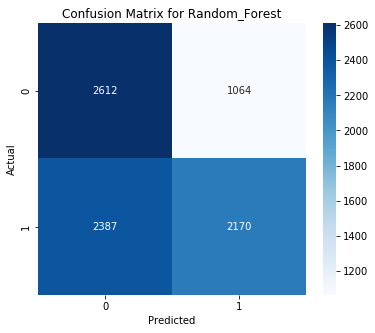

Generating Confusion Matrix for Logistic_Regression


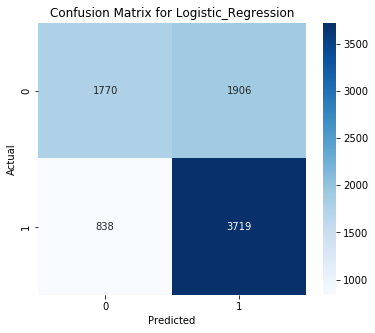

Generating Confusion Matrix for XGBoost


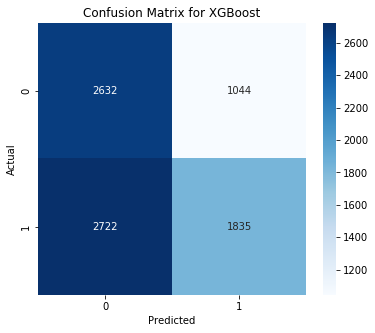

In [200]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, model_estimator in hyperparameters.items():
    print(f"Generating Confusion Matrix for {model_name}")

    # Make predictions on the encoded test set
    y_pred = model_estimator.predict(encoded_x_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [201]:
results = []

for model_name, model_estimator in hyperparameters.items():
    print(f"Evaluating {model_name}...")

    # Make predictions on the encoded test set
    y_pred = model_estimator.predict(encoded_x_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))


Evaluating Random_Forest...
Evaluating Logistic_Regression...
Evaluating XGBoost...

Model Performance Comparison:
Accuracy  F1-Score                Model  Precision    Recall
0.580833  0.577207        Random_Forest   0.604695  0.580833
0.666707  0.655864  Logistic_Regression   0.668981  0.666707
0.542573  0.533462              XGBoost   0.572284  0.542573
